# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [15]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
from typing import List, NoReturn
from math import exp, log

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [24]:
class Module:
    """
    Абстрактный класс. Его менять не нужно.
    """
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def params(self):
        pass

In [25]:
def l2_regularization(W, reg_strength):
    """
    Computes L2 regularization loss on weights and its gradient

    Arguments:
      W, np array - weights
      reg_strength - float value

    Returns:
      loss, single value - l2 regularization loss
      gradient, np.array same shape as W - gradient of weight by l2 loss
    """
    # TODO: Copy from the previous assignment
    loss = reg_strength*sum(sum(W**2));
    grad = reg_strength*2*W;
    
    return loss, grad

def cross_entropy_loss(probs, target_index):
    '''
    Computes cross-entropy loss

    Arguments:
      probs, np array, shape is either (N) or (batch_size, N) -
        probabilities for every class
      target_index: np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)

    Returns:
      loss: single value
    '''
    # TODO implement cross-entropy
    #print("probs:", probs);
    
    return -log(probs[target_index - 1]);


def softmax_with_cross_entropy(predictions, target_index):
    """
    Computes softmax and cross-entropy loss for model predictions,
    including the gradient

    Arguments:
      predictions, np array, shape is either (N) or (N, batch_size) -
        classifier output
      target_index: np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)

    Returns:
      loss, single value - cross-entropy loss
      dprediction, np array same shape as predictions - gradient of predictions by loss value
    """
    # TODO: Copy from the previous assignment
   # TODO implement softmax with cross-entropy
    
    #One-dimension option
    
    if predictions.ndim == 1:
        predictions_ = predictions - np.max(predictions);
        dprediction = np.array(list(map(exp, predictions_)));
        summ = sum(dprediction);
        dprediction /= summ;
        
        loss = cross_entropy_loss(dprediction, target_index);
        dprediction[target_index - 1] -= 1;
        
        return loss, dprediction;
    else:
    
        predictions_ = predictions - np.max(predictions, axis = 1)[:, np.newaxis];
        exp_vec = np.vectorize(exp);
        #print("predictions_:", predictions_);
        
        dprediction = np.apply_along_axis(exp_vec, 1, predictions_);
        #print("dprediction before division: ", dprediction);
    
        summ = sum(dprediction.T);
        #print("summ: ", summ);
        dprediction /= summ[:, np.newaxis];
            
        #print("dprediction after division: ", dprediction);
    
        loss = np.array([cross_entropy_loss(x,y) for x,y in zip(dprediction, target_index)]);
        #print("loss: ", loss);
        
        #print("target_index - 1:", target_index - 1);
        it = np.nditer(target_index - 1, flags = ['c_index'] )
        while not it.finished:
            #print("it[0] = ", it[0]);
            dprediction[it.index, it[0]] -= 1
            it.iternext()
        
        dprediction /= len(target_index);
        #print("dprediction after subtraction: ", dprediction);
    
        return loss.mean(), dprediction;
    raise Exception("Not implemented!")


class Param:
    """
    Trainable parameter of the model
    Captures both parameter value and the gradient
    """

    def __init__(self, value):
    #self.init = value.copy();
        self.value = value;
        self.grad = np.zeros_like(value);

class ReLU(Module):
    def __init__(self):
        self.X = None
        
    def forward(self, X):
        # TODO: Implement forward pass
        # Hint: you'll need to save some information about X
        # to use it later in the backward pass
        self.X = X;
        return (X > 0)*X;
    
    def backward(self, d_out):
        """
        Backward pass

        Arguments:
        d_out, np array (batch_size, num_features) - gradient
           of loss function with respect to output

        Returns:
        d_result: np array (batch_size, num_features) - gradient
          with respect to input
        """
        
        # TODO: Implement backward pass
        # Your final implementation shouldn't have any loops
        
        return (self.X > 0)*d_out;

    def params(self):
        # ReLU Doesn't have any parameters
        return {}


class Linear(Module):
    def __init__(self, n_input, n_output):
        self.W = Param(0.01 * np.random.randn(n_input, n_output))
        self.B = Param(0.01 * np.random.randn(1, n_output))
        self.X = None
        self.n_output = n_output
        
    def forward(self, X):
        # TODO: Implement forward pass
        # Your final implementation shouldn't have any loops
        self.X = X;
        #if np.any(self.W.init != self.W.value) or np.any(self.B.init != self.B.value):
        self.W.grad = np.zeros_like(self.W.value);
        self.B.grad = np.zeros_like(self.B.value);
        #    self.W.init = self.W.value;
        #    self.B.init = self.B.value;
        return np.dot(self.X, self.W.value) + self.B.value;

    def backward(self, d_out):
        """
        Backward pass
        Computes gradient with respect to input and
        accumulates gradients within self.W and self.B

        Arguments:
        d_out, np array (batch_size, n_output) - gradient
           of loss function with respect to output

        Returns:
        d_result: np array (batch_size, n_input) - gradient
          with respect to input
        """
        # TODO: Implement backward pass
        # Compute both gradient with respect to input
        # and gradients with respect to W and B
        # Add gradients of W and B to their `grad` attribute

        # It should be pretty similar to linear classifier from
        # the previous assignment
        
        dW = np.dot(self.X.T, d_out);
        dB = np.dot(np.ones((1, d_out.shape[0])), d_out);
        
        d_input = np.dot(d_out, self.W.value.T);
        
        self.W.grad += dW;
        self.B.grad += dB;
        
        return d_input;

    def params(self):
        return {'W': self.W, 'B': self.B}

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [26]:
class MLPClassifier:
    def __init__(self, modules: List[Module], reg = 2e-3):
        """
        Parameters
        ----------
        modules : List[Module]
            Cписок, состоящий из ранее реализованных модулей и 
            описывающий слои нейронной сети. 
            В конец необходимо добавить Softmax.
        reg, float - L2 regularization strength
        """
        self.reg = reg
        # TODO Create necessary layers
        self.modules = modules
        self.n_output = self.modules[-1].n_output
        
    def compute_loss_and_gradients(self, X, y):
        """
        Computes total loss and updates parameter gradients
        on a batch of training examples

        Arguments:
        X, np array (batch_size, input_features) - input data
        y, np array of int (batch_size) - classes
        """
        # Before running forward and backward pass through the model,
        # clear parameter gradients aggregated from the previous pass
        # TODO Set parameter gradient to zeros
        # Hint: using self.params() might be useful!
        for param in self.params():
            self.params()[param].grad = np.zeros_like(self.params()[param].grad);
        
        # TODO Compute loss and fill param gradients
        # by running forward and backward passes through the model
        predictions = X
        for module in self.modules:
            predictions = module.forward(predictions)
        
        loss, dX = softmax_with_cross_entropy(predictions, y + 1);
        for i in range(len(self.modules)-1, -1, -1):
            dX = self.modules[i].backward(dX)
        
        # After that, implement l2 regularization on all params
        # Hint: self.params() is useful again!
        for param in self.params():
            if(param[0] == 'W'):
                loss_, grad_ = l2_regularization(self.params()[param].value, self.reg);
                self.params()[param].grad += grad_;
                loss += loss_;
        return loss

    def predict(self, X):
        """
        Produces classifier predictions on the set

        Arguments:
          X, np array (test_samples, num_features)

        Returns:
          y_pred, np.array of int (test_samples)
        """
        # TODO: Implement predict
        # Hint: some of the code of the compute_loss_and_gradients
        # can be reused
        pred = np.zeros(X.shape[0], np.int)
        predictions = X
        for module in self.modules:
            predictions = module.forward(predictions)
        i=0;
        for predict in predictions:
            values = [softmax_with_cross_entropy(predict, target_index + 1)[0] \
                        for target_index in range(self.n_output)];
            pred[i] = min(range(len(values)), key=values.__getitem__);
            i += 1;
        return pred

    def params(self):
        result = {}
        # TODO Implement aggregating all of the params
        i = 1
        for module in self.modules:
            dict_module = module.params()
            if len(dict_module) > 0:
                for key in dict_module.keys():
                    result[key + str(i)] = dict_module[key];
                i += 1
        
        return result

In [27]:
from optim import SGD
from trainer import Trainer, Dataset
from dataset import random_split_train_val

model = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 32),
    ReLU(),
    Linear(32, 2)
])

X = np.random.randn(50, 4)
y = np.array([(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X])
train_X, train_y, val_X, val_y = random_split_train_val(X, y, num_val = 20)

dataset = Dataset(train_X, train_y, val_X, val_y);
trainer = Trainer(model, dataset, SGD(),  num_epochs=100, batch_size=100,
                  learning_rate=5e-1, learning_rate_decay= 0.95);

loss_history, train_history, val_history = trainer.fit()

/tmp/ipykernel_5526/3139534895.py:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = np.zeros(X.shape[0], np.int)


Loss: 0.693416, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.692531, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.692054, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691788, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691635, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691544, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691488, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691453, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691430, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691414, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691403, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691395, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691389, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691384, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691381, Train accuracy: 0.533333, val accuracy: 0.400000
Loss: 0.691378, Train acc

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [28]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

print(X[:10])
print(y[:10])

[[-1.03433496  0.04105682]
 [ 1.76605771 -0.18736136]
 [ 1.61936452 -0.25047369]
 [-0.9247644   0.56075625]
 [ 1.16215654  0.10360873]
 [ 1.74026995  0.0213692 ]
 [ 2.15053752  0.18210805]
 [ 0.21958816  0.01136422]
 [ 0.63353984  0.80059859]
 [ 1.81320861  0.26595535]]
[0 1 1 0 0 1 1 1 0 1]


In [29]:
best_acc = 0
model = MLPClassifier([
    Linear(2, 64),
    ReLU(),
    Linear(64, 2)
])
dataset = Dataset(X, y, X_test, y_test);
trainer = Trainer(model, dataset, SGD(), num_epochs=100, batch_size=64,
                  learning_rate=5e-2, learning_rate_decay=0.99);
loss_history, train_history, val_history = trainer.fit()
best_acc = max(np.mean(model.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

/tmp/ipykernel_5526/3139534895.py:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = np.zeros(X.shape[0], np.int)


Loss: 0.692768, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 0.692327, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 0.692669, Train accuracy: 0.785000, val accuracy: 0.787500
Loss: 0.691610, Train accuracy: 0.787500, val accuracy: 0.797500
Loss: 0.691548, Train accuracy: 0.792500, val accuracy: 0.802500
Loss: 0.690614, Train accuracy: 0.820000, val accuracy: 0.815000
Loss: 0.691822, Train accuracy: 0.785000, val accuracy: 0.787500
Loss: 0.692224, Train accuracy: 0.767500, val accuracy: 0.772500
Loss: 0.691370, Train accuracy: 0.795000, val accuracy: 0.792500
Loss: 0.688584, Train accuracy: 0.807500, val accuracy: 0.810000
Loss: 0.688053, Train accuracy: 0.792500, val accuracy: 0.810000
Loss: 0.684005, Train accuracy: 0.790000, val accuracy: 0.792500
Loss: 0.682429, Train accuracy: 0.795000, val accuracy: 0.807500
Loss: 0.682079, Train accuracy: 0.795000, val accuracy: 0.802500
Loss: 0.681011, Train accuracy: 0.797500, val accuracy: 0.795000
Loss: 0.681840, Train acc

In [30]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])

In [31]:
best_acc = 0
model = MLPClassifier([
    Linear(2, 64),
    ReLU(),
    Linear(64, 3)
])
dataset = Dataset(X, y, X_test, y_test);
trainer = Trainer(model, dataset, SGD(), num_epochs=100, batch_size=64,
                  learning_rate=5e-2, learning_rate_decay=0.99);
loss_history, train_history, val_history = trainer.fit()
best_acc = max(np.mean(model.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

/tmp/ipykernel_5526/3139534895.py:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = np.zeros(X.shape[0], np.int)


Loss: 1.094659, Train accuracy: 0.332500, val accuracy: 0.332500
Loss: 1.092625, Train accuracy: 0.332500, val accuracy: 0.332500
Loss: 1.103926, Train accuracy: 0.770000, val accuracy: 0.762500
Loss: 1.076684, Train accuracy: 0.720000, val accuracy: 0.717500
Loss: 1.068168, Train accuracy: 0.737500, val accuracy: 0.727500
Loss: 1.035866, Train accuracy: 0.707500, val accuracy: 0.707500
Loss: 1.006966, Train accuracy: 0.717500, val accuracy: 0.717500
Loss: 0.984552, Train accuracy: 0.755000, val accuracy: 0.760000
Loss: 0.850905, Train accuracy: 0.750000, val accuracy: 0.752500
Loss: 1.046216, Train accuracy: 0.780000, val accuracy: 0.777500
Loss: 0.741381, Train accuracy: 0.780000, val accuracy: 0.777500
Loss: 0.676928, Train accuracy: 0.780000, val accuracy: 0.775000
Loss: 0.524024, Train accuracy: 0.780000, val accuracy: 0.780000
Loss: 0.596873, Train accuracy: 0.790000, val accuracy: 0.790000
Loss: 0.910069, Train accuracy: 0.807500, val accuracy: 0.800000
Loss: 0.365530, Train acc

## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [33]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Files already downloaded and verified
Files already downloaded and verified


In [35]:
torch.cuda.is_available()

True

### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [36]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [37]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )
nn_model.type(torch.cuda.FloatTensor)

def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: torch.nn):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    return loss(model.forward(X), y) 

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [38]:
def train(model, epochs=20):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [39]:
train_l, test_l = train(nn_model)

Epoch 0 | Train loss 2.0831674994659424 | Test loss 1.8290363525390625
Epoch 1 | Train loss 1.7390293963241577 | Test loss 1.6492141250610353
Epoch 2 | Train loss 1.590431149520874 | Test loss 1.5179573949813843
Epoch 3 | Train loss 1.4846123386383057 | Test loss 1.457369924545288
Epoch 4 | Train loss 1.4091246754837037 | Test loss 1.3883760877609252
Epoch 5 | Train loss 1.356443648147583 | Test loss 1.3290432334899902
Epoch 6 | Train loss 1.3083702619171143 | Test loss 1.2982218536376953
Epoch 7 | Train loss 1.2722885869979859 | Test loss 1.25388401927948
Epoch 8 | Train loss 1.2477298760604858 | Test loss 1.2554021125793458
Epoch 9 | Train loss 1.2245239672088624 | Test loss 1.2226422241210937
Epoch 10 | Train loss 1.1951482787322998 | Test loss 1.1953569398880004
Epoch 11 | Train loss 1.1702125289535523 | Test loss 1.1872159814834595
Epoch 12 | Train loss 1.1548093476867676 | Test loss 1.1597872409820558
Epoch 13 | Train loss 1.1443623762893678 | Test loss 1.1469871904373168
Epoch 1

Построим график функции потерь

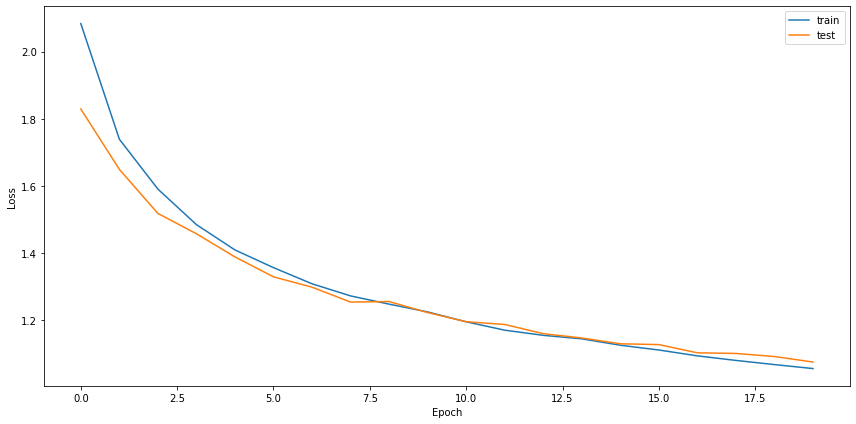

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [41]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = nn_model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.6282
Precision [0.68061224 0.73653846 0.48732943 0.48181818 0.57052632 0.51969981
 0.69325736 0.68036072 0.7549121  0.64608696]
Recall [0.667 0.766 0.5   0.371 0.542 0.554 0.73  0.679 0.73  0.743]
Mean Precision 0.6251141588289434
Mean Recall 0.6282
